# Импорт библиотек

In [1]:
import os
import random
import pandas as pd  
import spacy  # для токенизатора
import torch
from torch.nn.utils.rnn import pad_sequence  
from torch.utils.data import DataLoader, Dataset
from PIL import Image  
import torchvision.transforms as transforms

import torch
import torch.nn as nn
import torch.optim as optim
import statistics
import torchvision.models as models

from tqdm import tqdm
import torchvision.transforms as transforms

from fuzzywuzzy import fuzz

c:\Users\alex_\AppData\Local\Programs\Python\Python312\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


# Эмбэддинг слов

*Мы хотим преобразовать текст в числовые значения*
1. Нам нужен словарь, сопоставляющий каждое слово индексу
2. Нам нужно настроить набор данных Pytorch для загрузки данных
3. Настройка заполнения каждого батча (все предложения должны быть одной длины)

In [2]:
spacy_eng = spacy.load("en_core_web_sm")

***Токенезация предложений*** 

Токенезация = векторизация

Помимо эмбеддинга слов в вектора, используют специальные токены:

* `PAD` - используется для выравни вания предложений, если предложение больше установленной длины, слова обрезаются, если меньше - в предложение добавляется pad стольео раз, пока длина не достигнет необходимого значения

* `SOS` - "start of sentence" то же, что и <start> на картинке ниже - первый токен, который подается в декодер вместе с вектором, чтобы начать генерировать токены ответа
* `EOS` - "end of sentence" - то же, что и <end> на картинке ниже - как только декодер сгенерирует этот токен, мы считаем ответ полным (обычные знаки препинания для этой цели использовать нельзя, так как их значениея могут быть разные)

* `UNK` - "unknown token" - используется для замены редких слов, которые не вошли к ваш словарь. Например, предложение «Меня зовут guotong1999» будет переведено на «Меня зовут _unk_»

<img src='https://cloud.githubusercontent.com/assets/2272790/18410099/1d0a1c1a-7761-11e6-9fe1-bd2e5622b90a.png'>

In [3]:
# Создание словаря
class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]

    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4

        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                if word not in frequencies:
                    frequencies[word] = 1

                else:
                    frequencies[word] += 1

                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]

#  Загрузка Flickr8k датасета

In [4]:
class FlickrDataset(Dataset):
    def __init__(self, root_dir, captions_file, transform=None, freq_threshold=5):
        self.root_dir = root_dir
        self.df = pd.read_csv(captions_file)
        self.transform = transform

        # Сохраняем картинку и описание
        self.imgs = self.df["image"]
        self.captions = self.df["caption"]

        # Создаем словарь
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocabulary(self.captions.tolist())

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        caption = self.captions[index]
        img_id = self.imgs[index]
        img = Image.open(os.path.join(self.root_dir, img_id)).convert("RGB")
        #print(f"Загрузка изображения: {img_id}, размер: {img.size}")
        #print(f"Подпись: {caption}")
        if self.transform is not None:
            img = self.transform(img)

        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<EOS>"])

        return img, torch.tensor(numericalized_caption)



# Приводим описание картинок и их эмбеддинги к общему виду
class MyCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_idx)

        return imgs, targets


def get_loader(
    root_folder,
    annotation_file,
    transform,
    batch_size=32,
    shuffle=True,
    pin_memory=True,
):
    dataset = FlickrDataset(root_folder, annotation_file, transform=transform)

    pad_idx = dataset.vocab.stoi["<PAD>"]

    loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        pin_memory=pin_memory,
        collate_fn=MyCollate(pad_idx=pad_idx),
    )

    return loader, dataset


# Модель

Модель подписей к изображениям состоит из кодировщика и декодера. В качестве кодировщика выступает линейный слой, который используется сразу после предобученной ***CNN***. Декодера - ***RNN***. 

<img src='https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png'>

In [5]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size, train_CNN=False):
        super(EncoderCNN, self).__init__()
        self.train_CNN = train_CNN

        # Загрузка предобученной ResNet50 модели
        self.resnet = models.resnet50(pretrained=True)

        # Фиксация весов ResNet, если train_CNN = False
        for param in self.resnet.parameters():
            param.requires_grad = train_CNN

        # Замена последнего слоя на слой с нужным embed_size
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, embed_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, images):
        features = self.resnet(images)
        return self.dropout(self.relu(features))


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, features, captions):
        embeddings = self.dropout(self.embed(captions))
        # Вставка признаков из ResNet в LSTM
        embeddings = torch.cat((features.unsqueeze(0), embeddings), dim=0)
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs
        
    def generate_caption(self, features, vocabulary, max_length=50):
        result_caption = []

        with torch.no_grad():
            x = features.unsqueeze(0)
            states = None

            for _ in range(max_length):
                hiddens, states = self.lstm(x, states)
                output = self.linear(hiddens.squeeze(0))
                predicted = output.argmax(1)
                result_caption.append(predicted.item())
                x = self.embed(predicted).unsqueeze(0)

                if vocabulary.itos[predicted.item()] == "<EOS>":
                    break

        return [vocabulary.itos[idx] for idx in result_caption]


class CNNtoRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(CNNtoRNN, self).__init__()
        self.encoderCNN = EncoderCNN(embed_size)
        self.decoderRNN = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers)

    def forward(self, images, captions):
        features = self.encoderCNN(images)
        outputs = self.decoderRNN(features, captions)
        return outputs

    def caption_image(self, image, vocabulary, max_length=50):
        result_caption = []

        with torch.no_grad():
            x = self.encoderCNN(image).unsqueeze(0)
            states = None

            for _ in range(max_length):
                hiddens, states = self.decoderRNN.lstm(x, states)
                output = self.decoderRNN.linear(hiddens.squeeze(0))
                predicted = output.argmax(1)
                result_caption.append(predicted.item())
                x = self.decoderRNN.embed(predicted).unsqueeze(0)

                if vocabulary.itos[predicted.item()] == "<EOS>":
                    break

        return [vocabulary.itos[idx] for idx in result_caption]

# Обучение модели

In [13]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

loader, dataset = get_loader(
        "data/flickr8k/images/", "data/flickr8k/captions.txt", transform=transform
    )

# Гиперпараметры
embed_size = 258
hidden_size = 128

vocab_size = len(dataset.vocab)
num_layers = 1
learning_rate = 3e-4
num_epochs = 50

# Устройство (CPU или GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Создание модели
model = CNNtoRNN(embed_size, hidden_size, vocab_size, num_layers).to(device)

# Функция потерь и оптимизатор
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


# Цикл обучения
for epoch in range(num_epochs):
    print(f"[Epoch {epoch+1} / {num_epochs}]")

    # Создание прогресс-бара для каждой эпохи
    with tqdm(total=len(loader), leave=False) as loop:
        for i, (imgs, captions) in enumerate(loader):
            imgs = imgs.to(device)
            captions = captions.to(device)

            # Обнуление градиентов
            optimizer.zero_grad()

            # Проход вперед
            outputs = model(imgs, captions[:-1])
            loss = criterion(
                outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1)
            )

            # Обратное распространение ошибки
            loss.backward()

            # Обновление весов
            optimizer.step()

            # Обновление прогресс-бара
            loop.set_description(f"Loss: {loss.item():.4f}")
            loop.update(1)  # Обновляем на 1 шаг (1 батч)

    # Сохранение обученной модели
    
torch.save(model.state_dict(), f"model_resnet50_256_epoch_50.pth")
print("Обучение завершено!")

c:\Users\alex_\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\alex_\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[Epoch 1 / 50]


[Epoch 2 / 50]


[Epoch 3 / 50]


[Epoch 4 / 50]


[Epoch 5 / 50]


[Epoch 6 / 50]


[Epoch 7 / 50]


[Epoch 8 / 50]


[Epoch 9 / 50]


[Epoch 10 / 50]


[Epoch 11 / 50]


[Epoch 12 / 50]


[Epoch 13 / 50]


[Epoch 14 / 50]


[Epoch 15 / 50]


[Epoch 16 / 50]


[Epoch 17 / 50]


[Epoch 18 / 50]


[Epoch 19 / 50]


[Epoch 20 / 50]


[Epoch 21 / 50]


[Epoch 22 / 50]


[Epoch 23 / 50]


[Epoch 24 / 50]


[Epoch 25 / 50]


[Epoch 26 / 50]


[Epoch 27 / 50]


[Epoch 28 / 50]


[Epoch 29 / 50]


[Epoch 30 / 50]


[Epoch 31 / 50]


[Epoch 32 / 50]


[Epoch 33 / 50]


[Epoch 34 / 50]


[Epoch 35 / 50]


[Epoch 36 / 50]


[Epoch 37 / 50]


[Epoch 38 / 50]


[Epoch 39 / 50]


[Epoch 40 / 50]


[Epoch 41 / 50]


[Epoch 42 / 50]


[Epoch 43 / 50]


[Epoch 44 / 50]


[Epoch 45 / 50]


[Epoch 46 / 50]


[Epoch 47 / 50]


[Epoch 48 / 50]


[Epoch 49 / 50]


[Epoch 50 / 50]


Обучение завершено!


# Домашнее задание

Проанализируйте, как размер эмбеддинга влияет на качество модели.

Визуализируйте полученный результат подписи к нескольким изображениям, можно ли улучшить производительность сети?

c:\Users\alex_\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\alex_\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


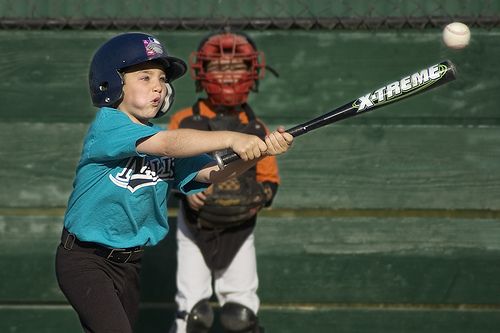

['<SOS>', 'a', 'man', 'in', 'a', 'red', 'shirt', 'is', 'jumping', 'up', 'in', 'the', 'air', '.', '<EOS>']


In [12]:
# Путь к сохраненным весам модели
model_path = "model_resnet50_128_epoch_50.pth"  # Замените на ваш путь

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

loader, dataset = get_loader(
        "data/flickr8k/images/", "data/flickr8k/captions.txt", transform=transform
    )

num_layers = 1
embed_size = 128
hidden_size = 128
vocab_size = len(dataset.vocab)

# Устройство (CPU или GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Загрузка обученной модели
model = CNNtoRNN(embed_size, hidden_size, vocab_size, num_layers).to(device)
model.load_state_dict(torch.load(model_path))
model.eval()  # Переключение модели в режим оценки (evaluation)

# Преобразование для изображения
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Функция для генерации подписи
def generate_caption(image_path):
    # Загрузка и предобработка изображения
    img = Image.open(image_path).convert("RGB")
    img = transform(img).unsqueeze(0).to(device)  # Добавляем размерность батча

    # Генерация подписи
    with torch.no_grad():
        features = model.encoderCNN(img)
        caption = model.decoderRNN.generate_caption(features, dataset.vocab)
        
    return caption

# Путь к изображению
image_path = "C:/PythonProjects/2year/16.DL_CV/data/flickr8k/Images/141139674_246c0f90a1.jpg"  # Замените на путь к вашему изображению
img = Image.open(image_path)
display(img)
# Генерация и вывод подписи
caption = generate_caption(image_path)
print(caption) 

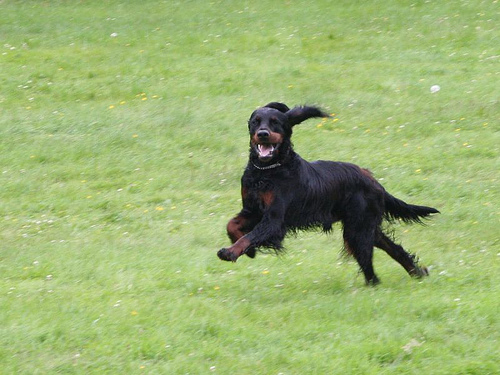

['<SOS>', 'a', 'black', 'and', 'white', 'dog', 'is', 'running', 'through', 'a', 'field', '.', '<EOS>']


In [13]:
# Путь к изображению
image_path = "C:/PythonProjects/2year/16.DL_CV/data/flickr8k/Images/232874193_c691df882d.jpg"  # Замените на путь к вашему изображению
img = Image.open(image_path)
display(img)
# Генерация и вывод подписи
caption = generate_caption(image_path)
print(caption) 

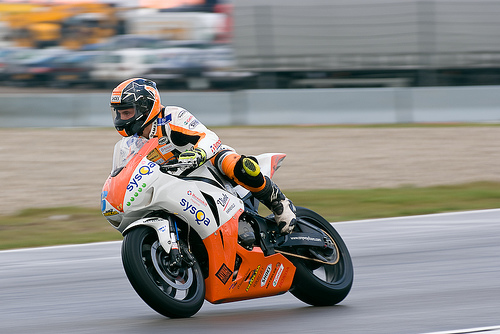

['<SOS>', 'a', 'man', 'in', 'a', 'red', 'jacket', 'is', 'riding', 'a', 'bike', 'on', 'a', 'track', '.', '<EOS>']


In [14]:
# Путь к изображению
image_path = "C:/PythonProjects/2year/16.DL_CV/data/flickr8k/Images/2739331794_4ae78f69a0.jpg"  # Замените на путь к вашему изображению
img = Image.open(image_path)
display(img)
# Генерация и вывод подписи
caption = generate_caption(image_path)
print(caption) 

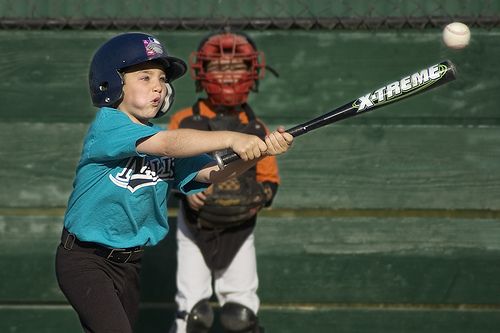

['<SOS>', 'a', 'man', 'in', 'a', 'blue', 'shirt', 'and', 'blue', 'shorts', 'is', 'playing', 'tennis', '.', '<EOS>']


In [9]:
# Путь к сохраненным весам модели
model_path = "model_resnet50_256_epoch_50.pth"  # Замените на ваш путь

embed_size = 258

# Загрузка обученной модели
model = CNNtoRNN(embed_size, hidden_size, vocab_size, num_layers).to(device)
model.load_state_dict(torch.load(model_path))
model.eval()  # Переключение модели в режим оценки (evaluation)

# Преобразование для изображения
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Функция для генерации подписи
def generate_caption(image_path):
    # Загрузка и предобработка изображения
    img = Image.open(image_path).convert("RGB")
    img = transform(img).unsqueeze(0).to(device)  # Добавляем размерность батча

    # Генерация подписи
    with torch.no_grad():
        features = model.encoderCNN(img)
        caption = model.decoderRNN.generate_caption(features, dataset.vocab)
        
    return caption

# Путь к изображению
image_path = "C:/PythonProjects/2year/16.DL_CV/data/flickr8k/Images/141139674_246c0f90a1.jpg"  # Замените на путь к вашему изображению
img = Image.open(image_path)
display(img)
# Генерация и вывод подписи
caption = generate_caption(image_path)
print(caption) 

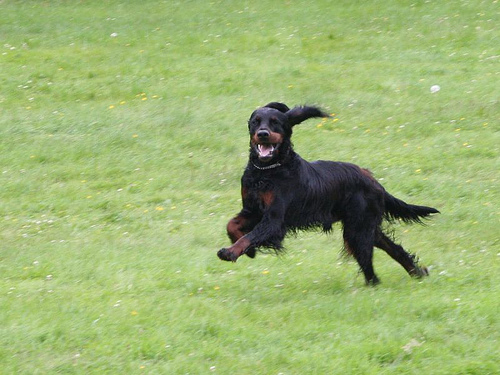

['<SOS>', 'a', 'black', 'dog', 'is', 'running', 'through', 'a', 'field', '.', '<EOS>']


In [10]:
# Путь к изображению
image_path = "C:/PythonProjects/2year/16.DL_CV/data/flickr8k/Images/232874193_c691df882d.jpg"  # Замените на путь к вашему изображению
img = Image.open(image_path)
display(img)
# Генерация и вывод подписи
caption = generate_caption(image_path)
print(caption) 

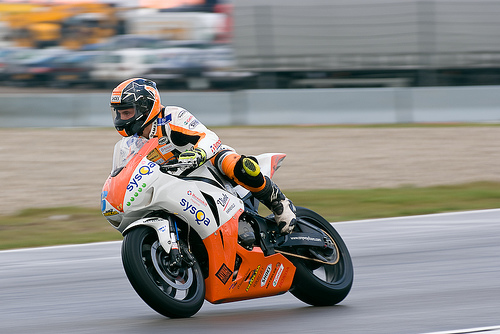

['<SOS>', 'a', 'race', 'car', 'is', 'driving', 'through', 'a', 'muddy', 'puddle', '.', '<EOS>']


In [11]:
# Путь к изображению
image_path = "C:/PythonProjects/2year/16.DL_CV/data/flickr8k/Images/2739331794_4ae78f69a0.jpg"  # Замените на путь к вашему изображению
img = Image.open(image_path)
display(img)
# Генерация и вывод подписи
caption = generate_caption(image_path)
print(caption) 

In [17]:
df = pd.read_csv("data/flickr8k/captions.txt")
df

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
...,...,...
40450,997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,A rock climber in a red shirt .


In [21]:
path = 'C:/PythonProjects/2year/16.DL_CV/data/flickr8k/Images/'

df['caption128'] = df['image'].apply(lambda x: generate_caption(path+x))

In [23]:
df['caption258'] = df['image'].apply(lambda x: generate_caption(path+x))

In [25]:
df.to_csv('captions.csv')

In [39]:
df = pd.read_csv('captions.csv')

In [40]:
def process_string(text):
    elements = eval(text)  # Преобразуем строку в список
    processed_text = ' '.join(elements[1:-1])  # Берем элементы с 1 по предпоследний
    return processed_text

In [41]:
df['caption128'] = df['caption128'].apply(process_string)
df['caption258'] = df['caption258'].apply(process_string)
df

,Unnamed: 0,image,caption,caption128,caption258
0,0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,a man in a blue shirt is sitting on a bench wi...,a woman in a black shirt and jeans is sitting ...
1,1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,a man in a blue shirt is sitting on a bench wi...,a woman in a black shirt and jeans is sitting ...
2,2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,a man in a blue shirt is sitting on a bench wi...,a woman in a black shirt and jeans is sitting ...
3,3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...,a man in a blue shirt is sitting on a bench wi...,a woman in a black shirt and jeans is sitting ...
4,4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...,a man in a blue shirt is sitting on a bench wi...,a woman in a black shirt and jeans is sitting ...
...,...,...,...,...,...
40450,40450,997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face,a man is climbing a rock wall .,a man is climbing a rock wall .
40451,40451,997722733_0cb5439472.jpg,A man is rock climbing high in the air .,a man is climbing a rock wall .,a man is climbing a rock wall .
40452,40452,997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...,a man is climbing a rock wall .,a man is climbing a rock wall .
40453,40453,997722733_0cb5439472.jpg,A rock climber in a red shirt .,a man is climbing a rock wall .,a man is climbing a rock wall .


In [49]:
df.iloc[0]['caption128']

'a man in a blue shirt is sitting on a bench with a .'

In [50]:
df['caption128'] = df['caption128'].str.replace('<UNK>','').str.strip().str.replace(r'\s+', ' ', regex=True)
df['caption258'] = df['caption258'].str.replace('<UNK>','').str.strip().str.replace(r'\s+', ' ', regex=True)
df

,Unnamed: 0,image,caption,caption128,caption258
0,0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,a man in a blue shirt is sitting on a bench wi...,a woman in a black shirt and jeans is sitting ...
1,1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,a man in a blue shirt is sitting on a bench wi...,a woman in a black shirt and jeans is sitting ...
2,2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,a man in a blue shirt is sitting on a bench wi...,a woman in a black shirt and jeans is sitting ...
3,3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...,a man in a blue shirt is sitting on a bench wi...,a woman in a black shirt and jeans is sitting ...
4,4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...,a man in a blue shirt is sitting on a bench wi...,a woman in a black shirt and jeans is sitting ...
...,...,...,...,...,...
40450,40450,997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face,a man is climbing a rock wall .,a man is climbing a rock wall .
40451,40451,997722733_0cb5439472.jpg,A man is rock climbing high in the air .,a man is climbing a rock wall .,a man is climbing a rock wall .
40452,40452,997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...,a man is climbing a rock wall .,a man is climbing a rock wall .
40453,40453,997722733_0cb5439472.jpg,A rock climber in a red shirt .,a man is climbing a rock wall .,a man is climbing a rock wall .


In [62]:
# Добавляем новый столбец с результатами сравнения
df['token_sort_ratio_128'] = df.apply(lambda row: fuzz.token_sort_ratio(row['caption'], row['caption128']), axis=1)
df['token_sort_ratio_258'] = df.apply(lambda row: fuzz.token_sort_ratio(row['caption'], row['caption258']), axis=1)

# Выводим DataFrame на экран
display(df)

,Unnamed: 0,image,caption,caption128,caption258,token_sort_ratio_128,token_sort_ratio_258
0,0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,a man in a blue shirt is sitting on a bench wi...,a woman in a black shirt and jeans is sitting ...,50,50
1,1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,a man in a blue shirt is sitting on a bench wi...,a woman in a black shirt and jeans is sitting ...,31,29
2,2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,a man in a blue shirt is sitting on a bench wi...,a woman in a black shirt and jeans is sitting ...,31,26
3,3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...,a man in a blue shirt is sitting on a bench wi...,a woman in a black shirt and jeans is sitting ...,26,17
4,4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...,a man in a blue shirt is sitting on a bench wi...,a woman in a black shirt and jeans is sitting ...,46,44
...,...,...,...,...,...,...,...
40450,40450,997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face,a man is climbing a rock wall .,a man is climbing a rock wall .,61,61
40451,40451,997722733_0cb5439472.jpg,A man is rock climbing high in the air .,a man is climbing a rock wall .,a man is climbing a rock wall .,75,75
40452,40452,997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...,a man is climbing a rock wall .,a man is climbing a rock wall .,43,43
40453,40453,997722733_0cb5439472.jpg,A rock climber in a red shirt .,a man is climbing a rock wall .,a man is climbing a rock wall .,62,62


In [63]:
display(df['token_sort_ratio_128'].mean())
display(df['token_sort_ratio_258'].mean())

44.2323075021629

45.43880855271289

## Вывод: Модель обучающаяся с большим размером эмбединга показывает результат лучше.